<a href="https://colab.research.google.com/github/ali-workshop/brain-tumar/blob/main/brain_tumar_final_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#download the dataset from kaggle website

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
# 6463b4d76523a3d511aadcdd9df378ec

In [ ]:
od.download("https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alolaa
Your Kaggle Key: ··········


100%|██████████| 188M/188M [00:02<00:00, 72.8MB/s]


#import libraries

In [ ]:
# import system libs
import os  # for operating system functionalities
import time  # for time-related operations
import shutil  # for high-level file operations
import pathlib  # for working with file paths
import itertools  # for efficient looping

# import data handling tools
import cv2  # OpenCV library for image processing
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation and analysis
import seaborn as sns  # for statistical data visualization
sns.set_style('darkgrid')  # set the seaborn plotting style
import matplotlib.pyplot as plt  # for plotting graphs and charts
from sklearn.model_selection import train_test_split  # for splitting data into training and testing sets
from sklearn.metrics import confusion_matrix, classification_report  # for evaluating classification models

# import Deep learning Libraries
import tensorflow as tf  # TensorFlow deep learning library
from tensorflow import keras  # TensorFlow's high-level neural networks API
from tensorflow.keras.models import Sequential  # for creating sequential models
from tensorflow.keras.optimizers import Adam, Adamax  # optimization algorithms
from tensorflow.keras.metrics import categorical_crossentropy  # loss function for categorical data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # for generating batches of image data
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization  # layers for building neural networks
from tensorflow.keras import regularizers  # for regularization techniques

# Ignore Warnings
import warnings  # for suppressing warnings
warnings.filterwarnings("ignore")  # ignore warning messages

print('modules loaded')  # print a message indicating that modules are loaded


modules loaded


#define helper functions to read the data

In [ ]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []  # list to store file paths
    labels = []  # list to store corresponding labels

    folds = os.listdir(dir)  # list all folders in the directory
    for fold in folds:  # iterate through each folder
        foldpath = os.path.join(dir, fold)  # create the full path of the folder
        filelist = os.listdir(foldpath)  # list all files in the folder
        for file in filelist:  # iterate through each file in the folder
            fpath = os.path.join(foldpath, file)  # create the full path of the file
            filepaths.append(fpath)  # append the file path to the list
            labels.append(fold)  # append the label (folder name) to the list

    return filepaths, labels  # return the lists of file paths and labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    # Create Pandas series for file paths and labels
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    # Concatenate the series along axis 1 to create the dataframe
    return pd.concat([Fseries, Lseries], axis=1)


In [ ]:
# Function that contains only a directory of data and it is not splitted
def tr_ts_data(tr_dir, ts_dir):
    # Generate train dataframe
    files, classes = define_paths(tr_dir)  # Get file paths and labels from the training directory
    df = define_df(files, classes)  # Create a dataframe from the file paths and labels
    strat = df['labels']  # Use labels for stratification during splitting
    train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)  # Split into train and validation sets

    # Generate test dataframe
    files, classes = define_paths(ts_dir)  # Get file paths and labels from the testing directory
    test_df = define_df(files, classes)  # Create a dataframe from the file paths and labels

    return train_df, valid_df, test_df  # Return train, validation, and test dataframes


# Function that contains train and test directory of data.
def full_data(data_dir):
    # Generate train dataframe
    files, classes = define_paths(data_dir)  # Get file paths and labels from the data directory
    df = define_df(files, classes)  # Create a dataframe from the file paths and labels
    strat = df['labels']  # Use labels for stratification during splitting
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)  # Split into train and a dummy set

    # Generate validation and test dataframes
    strat = dummy_df['labels']  # Use labels for stratification during splitting
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)  # Split dummy set into validation and test sets

    return train_df, valid_df, test_df  # Return train, validation, and test dataframes


# Function that contains the three directories of data: train, validation, and test
def tr_val_ts_data(tr_dir, val_dir, ts_dir):
    # Generate train dataframe
    files, classes = define_paths(tr_dir)  # Get file paths and labels from the training directory
    train_df = define_df(files, classes)  # Create a dataframe from the file paths and labels

    # Generate validation dataframe
    files, classes = define_paths(val_dir)  # Get file paths and labels from the validation directory
    valid_df = define_df(files, classes)  # Create a dataframe from the file paths and labels

    # Generate test dataframe
    files, classes = define_paths(ts_dir)  # Get file paths and labels from the testing directory
    test_df = define_df(files, classes)  # Create a dataframe from the file paths and labels

    return train_df, valid_df, test_df  # Return train, validation, and test dataframes


In [ ]:
def split_data(tr_dir, val_dir=None, ts_dir=None):
    '''
        This function split data into train, valid, and test after convert it to a dataframe.
        Dataset can be in several formats, it can contain train, valid, and test data, or it can contain only train and test data, etc.
        It depends on other needed function:
        - full_data function that contain only a directory of data and it is not splitted.
        - tr_ts_data function that contain train and test directory of data.
        - tr_val_ts_data function that contain the three directory of data train, valid, and test.
    '''

    # No Validation or Test data
    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    # No Validation data
    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    # All data existed
    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

In [ ]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen


#define helper class for Modeling

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')


#define function to plot the training

In [ ]:
def plot_training(hist):
    '''
    This function takes a training model and plots the history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']  # training accuracy
    tr_loss = hist.history['loss']  # training loss
    val_acc = hist.history['val_accuracy']  # validation accuracy
    val_loss = hist.history['val_loss']  # validation loss
    index_loss = np.argmin(val_loss)  # index of the epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]  # lowest validation loss
    index_acc = np.argmax(val_acc)  # index of the epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]  # highest validation accuracy
    Epochs = [i + 1 for i in range(len(tr_acc))]  # list of epochs
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label for the epoch with the lowest validation loss
    acc_label = f'best epoch= {str(index_acc + 1)}'  # label for the epoch with the highest validation accuracy

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


#enter the data path

In [ ]:
train_dir ="/content/brain-tumor-mri-images-44c"
valid_dir ='' #this dir is empty by default so we will use some of train_dir to fill it with some images
test_dir = ''#this dir is empty by default so we will use some of train_dir to fill it with some images
train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)
# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

Enter train data directory: /content/brain-tumor-mri-images-44c
Enter validation data directory (if no valid dir press Enter): 
Enter test data directory (if no test dir press Enter): 
Found 3582 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.
Found 448 validated image filenames belonging to 44 classes.


#build the model

In [ ]:
# Create Model Structure
img_size = (224, 224)  # image size
channels = 3  # number of image channels
img_shape = (img_size[0], img_size[1], channels)  # image shape
class_count = len(list(train_gen.class_indices.keys()))  # number of classes in the dataset

# Create pre-trained model (you can build on a pretrained model such as: EfficientNet, VGG, ResNet)
# We will use EfficientNetB3 from the EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,  # add the pretrained base model
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # batch normalization layer
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),  # dense layer with regularization
    Dropout(rate=0.45, seed=123),  # dropout layer
    Dense(class_count, activation='softmax')  # output layer with softmax activation
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  # compile the model

model.summary()  # print model summary


43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                         

#set configirations

In [ ]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#start training

In [ ]:
history = model.fit(x=train_gen,  # training data generator
                    epochs=epochs,  # number of epochs
                    verbose=0,  # no verbosity (silent)
                    callbacks=callbacks,  # callbacks for monitoring training
                    validation_data=valid_gen,  # validation data generator
                    validation_steps=None,  # number of validation steps
                    shuffle=False)  # do not shuffle the data during training


Do you want model asks you to halt the training [y/n] ?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     9.676   37.716   8.68665  41.741   0.00100  0.00100  accuracy     0.00    123.21 
 2 /40     7.177   66.164   6.57236  66.741   0.00100  0.00100  accuracy    75.43    56.62  
 3 /40     5.664   80.877   5.26019  78.125   0.00100  0.00100  accuracy    22.24    56.75  
 4 /40     4.563   88.414   4.30822  82.589   0.00100  0.00100  accuracy     9.32    57.33  
 5 /40     3.686   93.104   3.51708  86.830   0.00100  0.00100  val_loss    18.36    57.72  
 6 /40     2.984   95.142   2.81956  89.732   0.00100  0.00100  val_loss    19.83    57.02  
 7 /40     2.409   96.706   2.25475  93.080   0.00100  0.00100  val_loss    20.03    57.44  
 8 /40     1.947   97.850   1.85287  91.964   0.00100  0.00100  val_loss    17.82    57.55  
 9 /40     1.585   98.297   1.54067  93.973   0.00100  0.00100  val_loss    16.85    57.88  
10 /40     1.

#plot the training curves

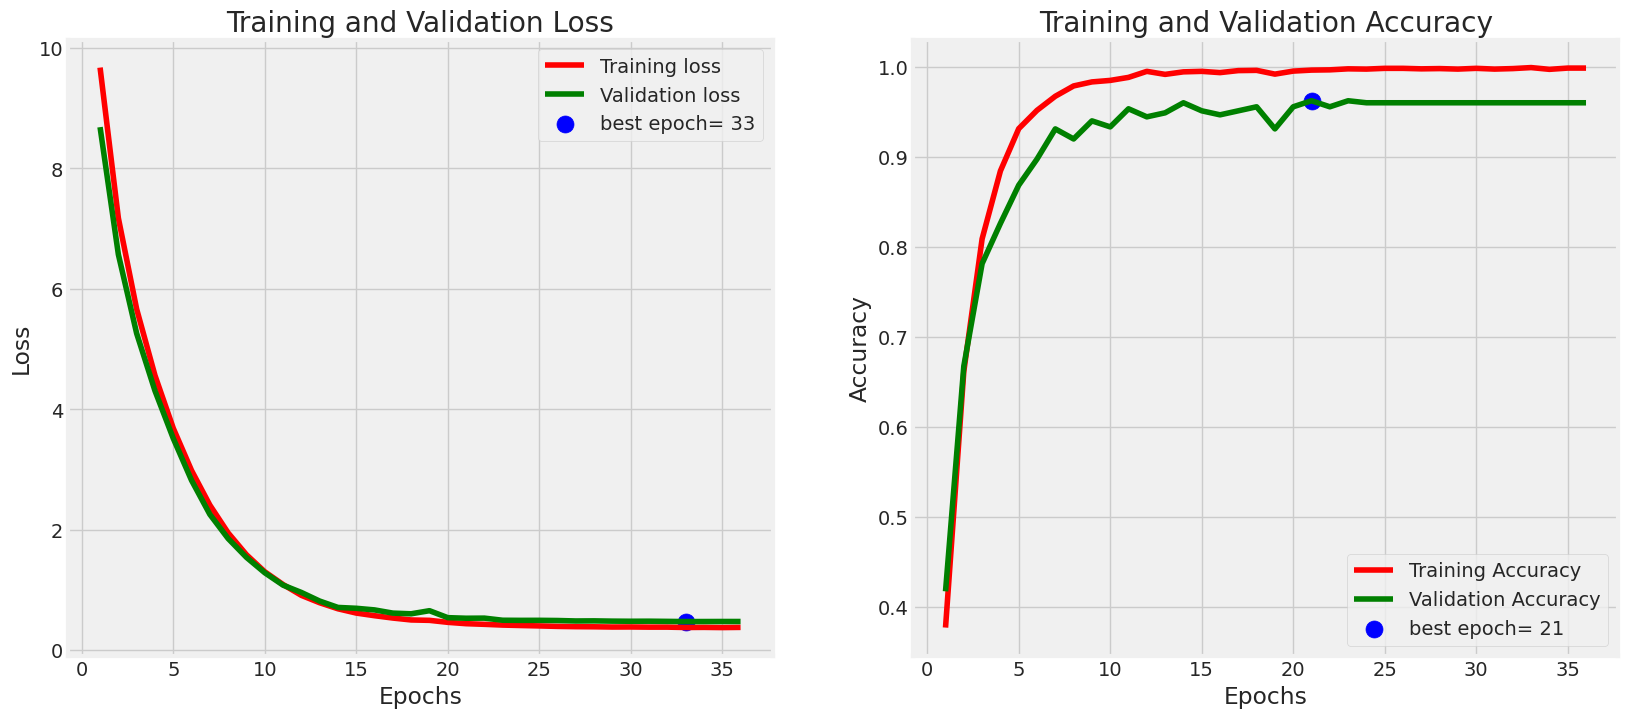

In [ ]:
plot_training(history)

#Evaluate the Model

In [ ]:
ts_length = len(test_df)  # length of the test dataset
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))  # calculate the test batch size
test_steps = ts_length // test_batch_size  # calculate the number of steps for testing

# Evaluate the model on the training data
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)

# Evaluate the model on the validation data
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


7/7 [==============================] - 5s 268ms/step - loss: 0.4434 - accuracy: 0.9754
Train Loss:  0.33188673853874207
Train Accuracy:  1.0
--------------------
Validation Loss:  0.4214301109313965
Validation Accuracy:  0.9714285731315613
--------------------
Test Loss:  0.4434177875518799
Test Accuracy:  0.9754464030265808


#Make predictions and print the classification report

In [ ]:
preds = model.predict_generator(test_gen)  # predict probabilities for the test data
y_pred = np.argmax(preds, axis=1)  # get the predicted classes
print(y_pred)  # print the predicted classes


[38 43 25  7 28 26 38 26 26 31 25  1 36 25 24 43 30 34 42 29  0 24 43 28
 25 27 43 30 26 27 16 27 43 42  2 42 24 27 42 43 26 12 26 37 27 40  1 24
 21  1  5 14 26  1 22 41 43  5 43 29 28 13 43 26 25  1  9 16 24  2 37  2
 34 27  2 36  7 36 24 36 24 36 42 28 37 42 18  1 37 24 24 28 42 33 39  1
 17  8 11 34 37 42  3  0 32  5  2 43 26 30  1 26 30  7 28  4 35 26 30 19
 40 25  3 25  1 22 25 28 33  3 25 39  0  0 42 26 24 34 36 41 17 24 36 27
  2  7  9  2 24 37 37  2 33 36 34 32 42 43 25 28 23 28  0 31  0 38 28  1
 24  6 26 24 31  5 43 38 28 37 11  4 27 43  4 13 24 27 40 26 24 41  4  3
 36 13  1 38 29 30 38 28 25  1 33 43 31 24 40 37 36 28 25 32 37 40 25 28
 16 32 29 42 42 29  1  2  1 15 25  0  5  7 38 32 27 40  1  1 43 26  2 25
 36 36 25 25  0 25 25 30  0 43 25  2  4  3  5 28 25 17 34  8 27 33 33 25
 29  0  0 28 18 26 37 34 42 25 29 22 26 36 42 25 43 27 35 42  1 35 21 38
 37 16 35  0 43 10  1 27 42 15  8 34 24 43 23  0 31  0 35 15 35 42  2 26
  1 25 28 25 32 38 43 22 35 15 22 34  4 25 24  0  2

In [ ]:
g_dict = test_gen.class_indices  # get the class indices from the test generator
classes = list(g_dict.keys())  # get the class labels

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))  # print the classification report


                        precision    recall  f1-score   support

        Astrocitoma T1       0.95      1.00      0.97        18
      Astrocitoma T1C+       1.00      1.00      1.00        24
        Astrocitoma T2       0.94      1.00      0.97        17
          Carcinoma T1       1.00      0.86      0.92         7
        Carcinoma T1C+       0.91      0.91      0.91        11
          Carcinoma T2       1.00      1.00      1.00         7
         Ependimoma T1       1.00      1.00      1.00         4
       Ependimoma T1C+       1.00      1.00      1.00         5
         Ependimoma T2       1.00      1.00      1.00         5
      Ganglioglioma T1       1.00      1.00      1.00         2
    Ganglioglioma T1C+       1.00      1.00      1.00         2
      Ganglioglioma T2       1.00      1.00      1.00         2
          Germinoma T1       1.00      1.00      1.00         2
        Germinoma T1C+       1.00      1.00      1.00         4
          Germinoma T2       1.00      